In [1]:
from PIL import Image
from torchfusion_utils.fp16 import convertToFP16
from torchfusion_utils.initializers import *
from torchfusion_utils.metrics import Accuracy
from torchfusion_utils.models import load_model,save_model

In [2]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [6]:
# Define data augmentation and transformation for training data
transforms_train = transforms.Compose([
    transforms.Resize(256),  # Resize to a larger size
    transforms.RandomRotation(15),  # Random rotation up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomCrop(224),  # Random crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transforms_test = transforms.Compose([
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


batch_sizes = 64
test_data_dir = './Datasets/Test_data'
train_data_dir = './Datasets/Training_data'

train_data = datasets.ImageFolder(root=train_data_dir, transform=transforms_train)
test_data = datasets.ImageFolder(root=test_data_dir, transform=transforms_test)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sizes, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_sizes, shuffle=True)

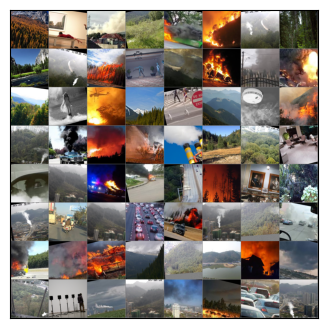

In [7]:
images, labels = next(iter(train_data_loader))

def image_display(image, title=None):
    image = image/2 + 0.5
    numpy_image = image.numpy()
    transposed_numpy_image = np.transpose(numpy_image, (1, 2, 0))
    plt.figure(figsize=(20, 4))
    plt.imshow(transposed_numpy_image)
    plt.yticks([])
    plt.xticks([])
    if title:
        plt.title(title)
    plt.show

image_display(torchvision.utils.make_grid(images))

In [8]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast

ResNet = models.alexnet(num_classes=3)
device = torch.device('cpu')  # Use CPU
Model = ResNet.to(device)
print(device)

lr = 0.001
weight_decay = 0.001  # L2 regularization parameter

criteria = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(Model.parameters(), lr=lr, weight_decay=weight_decay)

milestones = [100, 150]

scheduler = MultiStepLR(optimizer, milestones, gamma=0.1)

def model_training_and_validation_loop(Model, n_epochs, save_path):
    n_epochs = n_epochs
    saving_criteria_of_model = 0
    training_loss_array = []
    validation_loss_array = []
    train_acc = Accuracy()
    validation_acc = Accuracy(topK=1)

    for i in range(n_epochs):
        total_test_data = 0
        total_train_data = 0
        correct_test_data = 0
        training_loss = 0
        validation_loss = 0
        train_acc.reset()

        for data, target in train_data_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            with autocast():  # No mixed precision here
                predictions = Model(data)
                loss = criteria(predictions, target)

            loss.backward()
            optimizer.step()
            training_loss += loss.item() * data.size(0)
            train_acc.update(predictions, target)

        scheduler.step()

        with torch.no_grad():
            validation_acc.reset()

            for data, target in test_data_loader:
                data, target = data.to(device), target.to(device)
                predictions = Model(data)
                loss = criteria(predictions, target)
                validation_acc.update(predictions, target)
                total_test_data += target.size(0)
                validation_loss += loss.item() * data.size(0)

        training_loss = training_loss / len(train_data_loader.dataset)
        validation_loss = validation_loss / total_test_data

        training_loss_array.append(training_loss)
        validation_loss_array.append(validation_loss)

        print(f'{i+1}/{n_epochs} Training loss: {training_loss}, Tran_Accuracy: {train_acc.getValue()}, Validation_loss: {validation_loss}, Validation_Accuracy: {validation_acc.getValue()}')

        if saving_criteria_of_model < validation_acc.getValue():
            torch.save(Model, save_path)
            saving_criteria_of_model = validation_acc.getValue()
            print('--------------------------Saving Model---------------------------')

    plt.figure(figsize=(20, 4))
    x_axis = range(n_epochs)
    plt.plot(x_axis, training_loss_array, 'r', validation_loss_array, 'b')
    plt.title('A graph of training loss vs validation loss')
    plt.legend(['train loss', 'validation loss'])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')

    return Model


cpu


In [9]:
# n_epochs = 20
# model = model_training_and_validation_loop(Model, n_epochs, 'fire-flame.pt')
import os
save_path = 'Models/fire-flame.pt'
if not os.path.exists(save_path):
    n_epochs = 20
    model = model_training_and_validation_loop(Model, n_epochs, save_path)
else:
    print(f"Model file '{save_path}' already exists. Skipping training.")

Model file 'Models/fire-flame.pt' already exists. Skipping training.


In [12]:
load_saved_model = torch.load('Models/fire-flame.pt', map_location=torch.device('cpu'))
dummy_input = torch.FloatTensor(1,3,224,224)
dummy_input = dummy_input.to(device)
torch.onnx.export(load_saved_model, dummy_input, 'Models/fire-flame.onnx')


In [14]:
# img_path ='3.jpeg'
img_path = 'Tests/fire.jfif'

In [17]:
import torch
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# def inference_function_gpu(img_path):
#     def image_display(img_path):
#         plt.figure(figsize=(30, 6))
#         plt.imshow(Image.open(img_path))
#         plt.yticks([])
#         plt.xticks([])
#         plt.show()
#         return 'Image of:'

#     def model_inference_results():
#         transformer = transforms.Compose([
#             transforms.Resize(225),
#             transforms.CenterCrop(224),
#             transforms.ToTensor(),
#             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         ])

#         # Load the model to GPU if available
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#         img = Image.open(img_path)
#         img_processed = transformer(img).unsqueeze(0)
#         img_var = Variable(img_processed, requires_grad=False).to(device)

#         # Load the model to GPU if available
#         load_saved_model = torch.load('fire-flame.pt')
#         load_saved_model = load_saved_model.to(device)

    #     load_saved_model.eval()
    #     logp = load_saved_model(img_var)
    #     expp = torch.softmax(logp, dim=1)
    #     confidence, clas = expp.topk(1, dim=1)
    #     class_name = ('Fire', 'Neutral', 'Smoke')

    #     return f'Class: {class_name[clas]}', f'Confidence score: {confidence.item()}'

    # return (image_display(img_path), *model_inference_results())

def inference_function_gpu(img_path):
    def image_display(img_path):
        plt.figure(figsize=(30, 6))
        plt.imshow(Image.open(img_path))
        plt.yticks([])
        plt.xticks([])
        plt.show()
        return 'Image of:'

    def model_inference_results():
        transformer = transforms.Compose([
            transforms.Resize(225),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

        # Load the model to CPU
        device = torch.device("cpu")

        img = Image.open(img_path)
        img_processed = transformer(img).unsqueeze(0)
        img_var = Variable(img_processed, requires_grad=False).to(device)

        # Load the model to CPU
        load_saved_model = torch.load('Models/fire-flame.pt', map_location=device)
        load_saved_model = load_saved_model.to(device)

        load_saved_model.eval()
        logp = load_saved_model(img_var)
        expp = torch.softmax(logp, dim=1)
        confidence, clas = expp.topk(1, dim=1)
        class_name = ('Fire', 'Neutral', 'Smoke')

        return f'Class: {class_name[clas]}', f'Confidence score: {confidence.item()}'

    return (image_display(img_path), *model_inference_results())


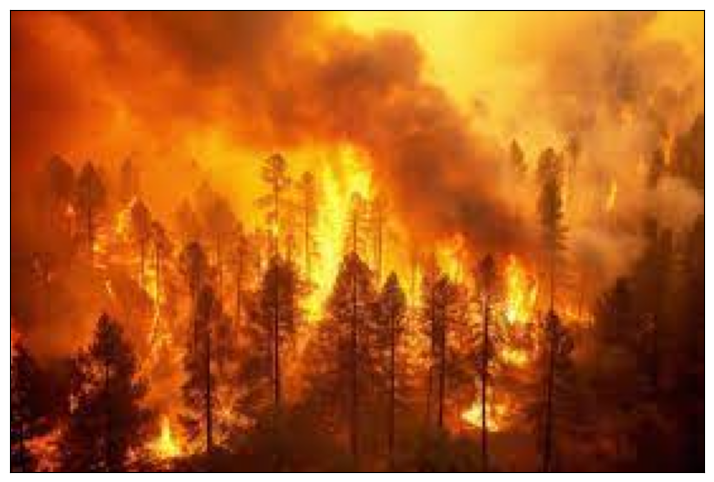

('Image of:', 'Class: Fire', 'Confidence score: 0.9997153878211975')

In [18]:
inference_function_gpu(img_path)

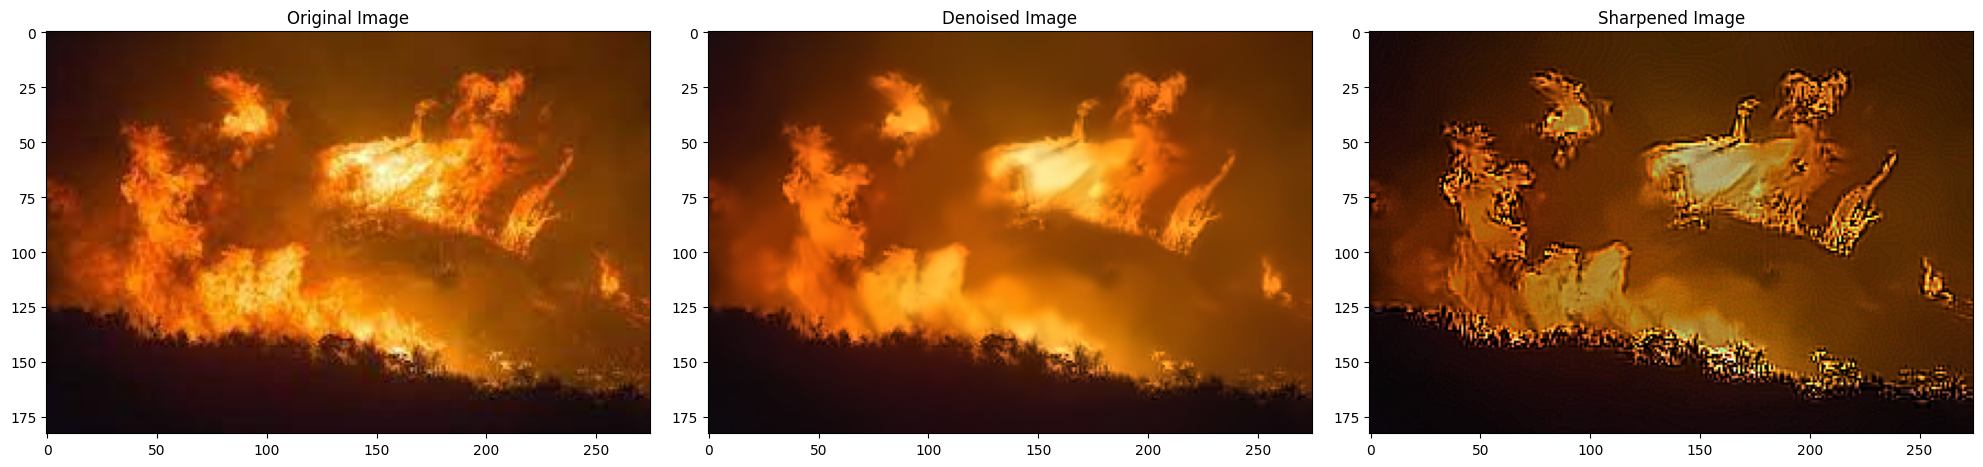

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
image_path = 'Tests/noisy.jfif'
image = cv2.imread(image_path)

# Denoise the image
dst = cv2.fastNlMeansDenoisingColored(image, None, 6, 13, 7, 21)

# Create a sharpening kernel
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])

# Scale the kernel for stronger sharpening
sharpening_factor = 0.7
sharpening_kernel = kernel * sharpening_factor

# Apply sharpening using the filter2D function on the denoised image
sharpened_image = cv2.filter2D(dst, -1, sharpening_kernel)

cv2.imwrite('Results/sharpened_image.jpg', sharpened_image)
cv2.imwrite('Results/denoised_image.jpg', dst)

# Display the original, denoised, and sharpened images side by side
row, col = 1, 3
fig, axs = plt.subplots(row, col, figsize=(20, 10))
fig.tight_layout()

axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')

axs[1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
axs[1].set_title('Denoised Image')

axs[2].imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
axs[2].set_title('Sharpened Image')

plt.show()



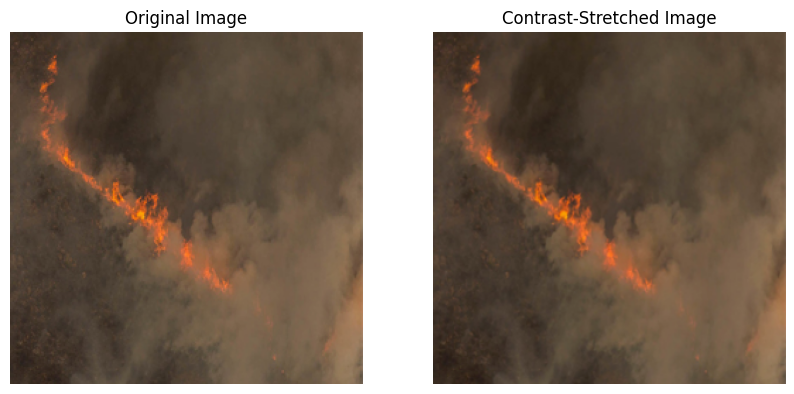

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image_path = 'Tests/low_contrast.jfif'
original_image = cv2.imread(image_path)

# Resize
target_size = (300, 300)
resized_image = cv2.resize(original_image, target_size)

# Convert to float32
float_image = resized_image.astype(np.float32)

# Normalize
normalized_image = cv2.normalize(float_image, None, 0, 255, cv2.NORM_MINMAX)
contrast_stretched_image = normalized_image.astype(np.uint8)

# Display images with labels using matplotlib
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Contrast-Stretched Image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contrast_stretched_image, cv2.COLOR_BGR2RGB))
plt.title('Contrast-Stretched Image')
plt.axis('off')

plt.show()


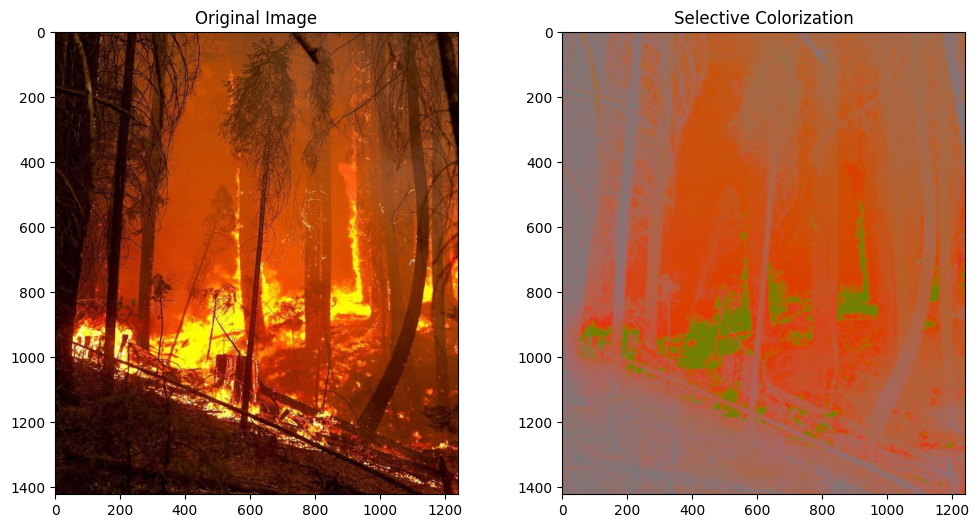

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def selective_colorization(image, color_to_keep):
    # Convert the image to the LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into L, A, and B channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Create a mask for the color to keep
    color_mask = cv2.inRange(lab_image, color_to_keep, color_to_keep)

    # Set non-matching pixels to grayscale in the L channel
    l_channel[color_mask == 0] = 128

    # Merge the channels back together
    colorized_image = cv2.merge([l_channel, a_channel, b_channel])

    # Convert the colorized image back to BGR
    colorized_image = cv2.cvtColor(colorized_image, cv2.COLOR_LAB2BGR)

    return colorized_image

# Example: Keep the color corresponding to red
image_path = 'Tests/3.jpeg'
original_image = cv2.imread(image_path)

# Define the color range for red in LAB space
color_to_keep = (0, 128, 128)

# Apply selective colorization
colorized_image = selective_colorization(original_image, color_to_keep)

# Save the result in the same directory
result_path = 'Results/selective_colorized_image.jpg'
cv2.imwrite(result_path, colorized_image)

# Display the original and colorized images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB))
plt.title('Selective Colorization')

plt.show()


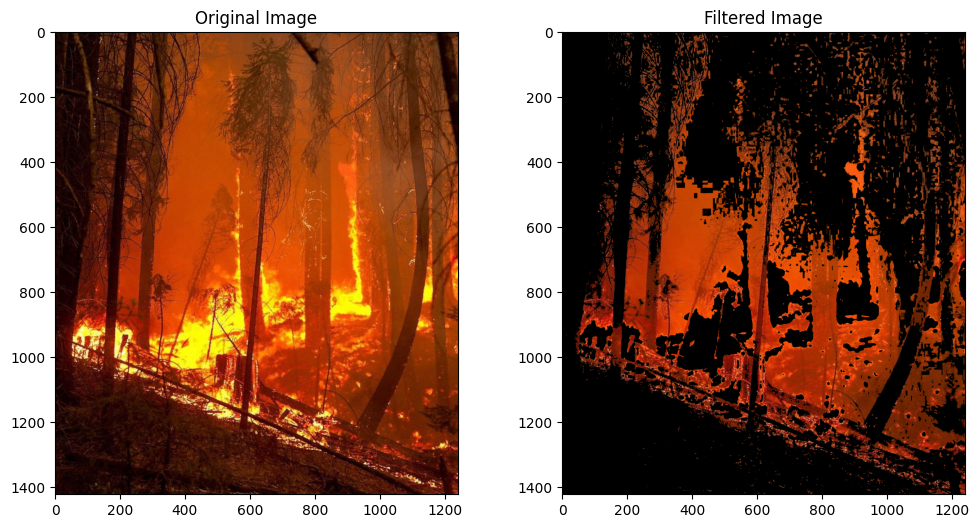

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def color_filter(image, lower_bound, upper_bound):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result
img_path = '3.jpeg'
image = cv2.imread(img_path)

# Example: Enhance red colors
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])

filtered_image = color_filter(image, lower_red, upper_red)

# Display the original and filtered images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
plt.title('Filtered Image')

plt.show()

In [30]:
import telepot
import torch
from torchvision import transforms
from PIL import Image


bot_token = '6542797845:AAFf5SO3yLQ3bmpBDyVxRieUssn6_JRckmY'
target_chat_id = input("Enter your Telegram chat ID: ")

# Initialize Telegram bot with user-provided token
bot = telepot.Bot(bot_token)

# Load the image classification model
load_saved_model = torch.load('Models/fire-flame.pt', map_location=torch.device('cpu'))
load_saved_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define function to send Telegram alert
def send_telegram_alert(message, image_path):
    with open(image_path, 'rb') as photo:
        bot.sendPhoto(target_chat_id, photo, caption=message)

# Function to perform image classification
def image_classification(image_path):
    transformer = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path)
    img_processed = transformer(img).unsqueeze(0)
    img_var = img_processed.to(device)

    with torch.no_grad():
        output = load_saved_model(img_var)

    probabilities = torch.softmax(output, dim=1)
    confidence, clas = probabilities.topk(1, dim=1)
    class_names = ('Fire', 'Neutral', 'Smoke')

    return class_names[clas.item()], confidence.item()

# Function to send alert if image class is fire or smoke
def main(image_path):
    image_class, confidence = image_classification(image_path)

    print(f"Class: {image_class}, Confidence: {confidence:.2f}")

    if image_class in ['Fire', 'Smoke']:
        message = f"Class: {image_class} detected in the image! - Confidence: {confidence:.2f}"
        send_telegram_alert(message, image_path)
    else:
        print("No fire or smoke detected in the image or no relevant class found.")

if __name__ == "__main__":
    image_path = "Tests/3.jpeg"
    main(image_path)


Class: Fire, Confidence: 1.00
